# 1. Sleep well (35 points)

In [1]:
n_jobs = 2
cv = 3
scoring = 'accuracy'
digits = 4

In [2]:
import pandas as pd

# Load the data
X_train = pd.read_csv('data\Sleep-EDF-15_U-Time/X_train.csv', header=None)
y_train = pd.read_csv('data\Sleep-EDF-15_U-Time/y_train.csv', header=None)
X_test = pd.read_csv('data\Sleep-EDF-15_U-Time/X_test.csv', header=None)
y_test = pd.read_csv('data\Sleep-EDF-15_U-Time/y_test.csv', header=None)

## 1.1 Data understanding and preprocessing

Class frequencies for training data:
Class (0.0,): 52.09%
Class (1.0,): 9.55%
Class (2.0,): 25.27%
Class (3.0,): 4.69%
Class (4.0,): 8.39%


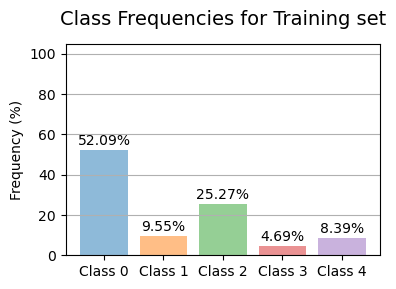

In [3]:
import matplotlib.pyplot as plt

# Calculate class frequencies for training data, normalized to [0,1]
class_frequencies = y_train.value_counts(normalize=True).sort_index()

# Print each class frequency for training data
print('Class frequencies for training data:')
for label, freq in class_frequencies.items():
    print(f'Class {label}: {freq*100:.2f}%')

# Plotting
labels = [f'Class {i}' for i in range(0, 5)]
freqs = class_frequencies.values * 100

plt.figure(figsize=(4, 3))
bars = plt.bar(labels, freqs, color=plt.cm.tab10.colors, alpha=0.5)

# Add annotations to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.ylabel('Frequency (%)')
plt.title('Class Frequencies for Training set', fontsize=14, y=1.05)
plt.ylim(0, 105)  # Adjusted to make space for annotations
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/class_frequencies.png')
plt.show()

## 1.2 Classification

### Helper methods to hyperparameter tuning, evaluation and plotting

In [4]:
from sklearn.metrics import classification_report, zero_one_loss
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

def hyperparameter_tuning(estimator, param_grid, X_train, y_train, cv, n_jobs, scoring):
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                               return_train_score=True,
                               cv=cv,
                               n_jobs=n_jobs,
                               scoring=scoring)
    grid_search.fit(X_train, y_train.values.ravel())
    best_model = grid_search.best_estimator_
    best_train_pred = best_model.predict(X_train)
    best_test_pred = best_model.predict(X_test)
    return grid_search, best_train_pred, best_test_pred

def evaluate_classifier(grid_search, y_true_train, y_best_pred_train, y_true_test, y_best_pred_test, classifier_name):
    # Print the best model found
    print('Best Hyperparameters:', grid_search.best_params_)

    train_zero_one_loss = zero_one_loss(y_true_train, y_best_pred_train)
    train_report = classification_report(y_true_train, y_best_pred_train, digits=digits)

    test_zero_one_loss = zero_one_loss(y_true_test, y_best_pred_test)
    test_report = classification_report(y_true_test, y_best_pred_test, digits=digits)

    print(f'\nEvaluation Metrics for {classifier_name}:\n')

    print(f'(Best) Train Zero-One Loss: {train_zero_one_loss:.{digits}f}')
    print(f'(Best) Train Classification Report:\n{train_report}')

    print(f'(Best) Test Zero-One Loss: {test_zero_one_loss:.{digits}f}')
    print(f'(Best) Test Classification Report:\n{test_report}')

    # Print results for all combinations
    print('-' * 50)
    print('\nAll results:')
    for i in range(len(grid_search.cv_results_['params'])):
        print(f'Combination {i+1}:')
        print('Parameters:', grid_search.cv_results_['params'][i])
        print(f"Training Accuracy: {grid_search.cv_results_['mean_train_score'][i]:.{digits}f}")
        print(f"Validation Accuracy: {grid_search.cv_results_['mean_test_score'][i]:.{digits}f}")
        print('-' * 50)

def plot_results(grid_search, param_name, title, xlabel, filename, log_scale=False):
    param_values = [0 if v is None else v for v in grid_search.cv_results_[f'param_{param_name}'].data] # in case of None value convert to 0
    param_values = np.array(param_values, dtype=float)
    train_accuracy = np.array(grid_search.cv_results_['mean_train_score']*100, dtype=float)
    vali_accuracy = np.array(grid_search.cv_results_['mean_test_score']*100, dtype=float)
    train_std = np.array(grid_search.cv_results_['std_train_score']*100, dtype=float)
    vali_std = np.array(grid_search.cv_results_['std_test_score']*100, dtype=float)

    plt.figure(figsize=(5, 4))
    plt.plot(param_values, train_accuracy, label='Train', color='tab:blue', alpha=0.6)
    plt.fill_between(param_values, train_accuracy - train_std, train_accuracy + train_std, color='tab:blue', alpha=0.25)
    plt.plot(param_values, vali_accuracy, label='Validation', color='tab:red', alpha=0.6)
    plt.fill_between(param_values, vali_accuracy - vali_std, vali_accuracy + vali_std, color='tab:red', alpha=0.15)
    plt.suptitle(title, fontsize=14, y=0.94)
    plt.xlabel(xlabel)
    if log_scale:
        plt.xscale('log')
    plt.ylabel('Mean Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

### Multi-nominal Logistic Regression

Best Hyperparameters: {'C': 0.01}

Evaluation Metrics for Logistic Regression:

(Best) Train Zero-One Loss: 0.1526
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0     0.9611    0.9676    0.9643     17566
         1.0     0.5562    0.4027    0.4671      3221
         2.0     0.7760    0.8360    0.8049      8523
         3.0     0.6909    0.5944    0.6390      1583
         4.0     0.7013    0.7838    0.7403      2831

    accuracy                         0.8474     33724
   macro avg     0.7371    0.7169    0.7231     33724
weighted avg     0.8411    0.8474    0.8425     33724

(Best) Test Zero-One Loss: 0.0968
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.9812    0.9825    0.9818      7579
         1.0     0.4712    0.5381    0.5024       775
         2.0     0.9098    0.8740    0.8915      3841
         3.0     0.7129    0.7418    0.7270       395
         4.0     0.7

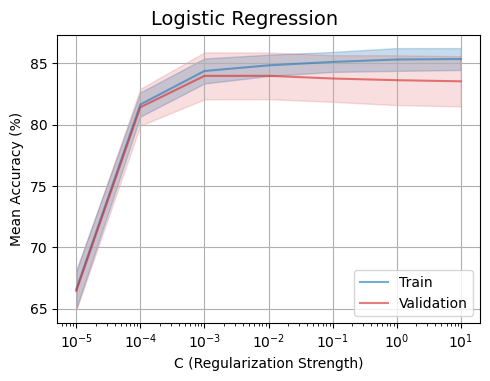

In [5]:
from sklearn.linear_model import LogisticRegression

lr_param = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
lr_grid_search, lr_best_train_pred, lr_best_test_pred = hyperparameter_tuning(estimator=LogisticRegression(max_iter=10000, n_jobs=n_jobs),
                                                                              param_grid=lr_param,
                                                                              X_train=X_train,
                                                                              y_train=y_train,
                                                                              cv=cv,
                                                                              n_jobs=n_jobs,
                                                                              scoring=scoring)

evaluate_classifier(grid_search=lr_grid_search,
                    y_true_train=y_train,
                    y_best_pred_train=lr_best_train_pred,
                    y_true_test=y_test,
                    y_best_pred_test=lr_best_test_pred,
                    classifier_name='Logistic Regression')

plot_results(grid_search=lr_grid_search,
             param_name='C',
             title='Logistic Regression',
             xlabel='C (Regularization Strength)',
             filename='output/lr.png',
             log_scale=True)

### Random Forests

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 100}

Evaluation Metrics for Random Forest:

(Best) Train Zero-One Loss: 0.1488
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0     0.9598    0.9702    0.9650     17566
         1.0     0.5626    0.4297    0.4872      3221
         2.0     0.7760    0.8557    0.8139      8523
         3.0     0.7597    0.5313    0.6253      1583
         4.0     0.7143    0.7577    0.7353      2831

    accuracy                         0.8512     33724
   macro avg     0.7545    0.7089    0.7253     33724
weighted avg     0.8454    0.8512    0.8459     33724

(Best) Test Zero-One Loss: 0.1004
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.9726    0.9844    0.9785      7579
         1.0     0.4571    0.5161    0.4848       775
         2.0     0.9019    0.8831    0.8924      3841
         3.0     0.7566    0.6532    0.7011       395


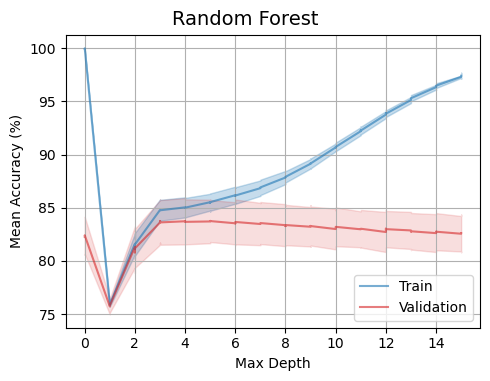

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning
rf_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, *range(1, 16)],  # * unpack the range into the list
}

rf_grid_search, rf_best_train_pred, rf_best_test_pred = hyperparameter_tuning(estimator=RandomForestClassifier(n_jobs=n_jobs),
                                                                              param_grid=rf_param,
                                                                              X_train=X_train,
                                                                              y_train=y_train,
                                                                              cv=cv,
                                                                              n_jobs=n_jobs,
                                                                              scoring=scoring)

evaluate_classifier(grid_search=rf_grid_search,
                    y_true_train=y_train,
                    y_best_pred_train=rf_best_train_pred,
                    y_true_test=y_test,
                    y_best_pred_test=rf_best_test_pred,
                    classifier_name='Random Forest')

plot_results(grid_search=rf_grid_search,
             param_name='max_depth',
             title='Random Forest',
             xlabel='Max Depth',
             filename='output/rf.png')

### k-Nearest-Neighbor

Best Hyperparameters: {'n_neighbors': 103}

Evaluation Metrics for K-Nearest Neighbors:

(Best) Train Zero-One Loss: 0.1477
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0     0.9614    0.9694    0.9654     17566
         1.0     0.5773    0.4303    0.4931      3221
         2.0     0.7796    0.8539    0.8151      8523
         3.0     0.7603    0.5250    0.6211      1583
         4.0     0.6980    0.7845    0.7387      2831

    accuracy                         0.8523     33724
   macro avg     0.7553    0.7126    0.7267     33724
weighted avg     0.8472    0.8523    0.8471     33724

(Best) Test Zero-One Loss: 0.0966
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.9789    0.9840    0.9814      7579
         1.0     0.4777    0.5381    0.5061       775
         2.0     0.9043    0.8784    0.8912      3841
         3.0     0.7651    0.6430    0.6988       395
         4.

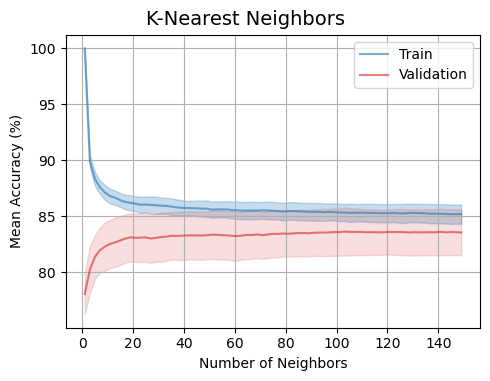

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
# As a rule of thumb the number of neighbors in a set should be sqrt(n) where n is the number of samples in the set: https://quantdev.ssri.psu.edu/sites/qdev/files/kNN_tutorial.html
# K-neighbors should be an odd value in KNN to avoid ties at decision boundaries
# where majority voting occurs. Using odd numbers helps prevent ties.
knn_param = {'n_neighbors': range(1, 150, 2)}  # Considering 1 to 149 neighbors (odd numbers)

knn_grid_search, knn_best_train_pred, knn_best_test_pred = hyperparameter_tuning(estimator=KNeighborsClassifier(n_jobs=n_jobs),
                                                                              param_grid=knn_param,
                                                                              X_train=X_train,
                                                                              y_train=y_train,
                                                                              cv=cv,
                                                                              n_jobs=n_jobs,
                                                                              scoring=scoring)

evaluate_classifier(grid_search=knn_grid_search,
                    y_true_train=y_train,
                    y_best_pred_train=knn_best_train_pred,
                    y_true_test=y_test,
                    y_best_pred_test=knn_best_test_pred,
                    classifier_name='K-Nearest Neighbors')

plot_results(grid_search=knn_grid_search,
             param_name='n_neighbors',
             title='K-Nearest Neighbors',
             xlabel='Number of Neighbors',
             filename='output/knn.png')

# 2. Invariance and normalization (30 points)

Mean of age: 34.5
Mean of income: 37.5

Centered coordinates for Mr. Good: [12.5 -2.5]
Centered coordinates for Mr. Bad: [-12.5   2.5]
Centered coordinates for Mr. Unknown: [-13.5  -1.5]

Variance of age: 156.25
Variance of income: 6.25

Standard deviation of age: 12.5
Standard deviation of income: 2.5

Normalized coordinates for Mr. Good: [1.0, -1.0]
Normalized coordinates for Mr. Bad: [-1.0, 1.0]
Normalized coordinates for Mr. Unknown: [-1.08, -0.6]


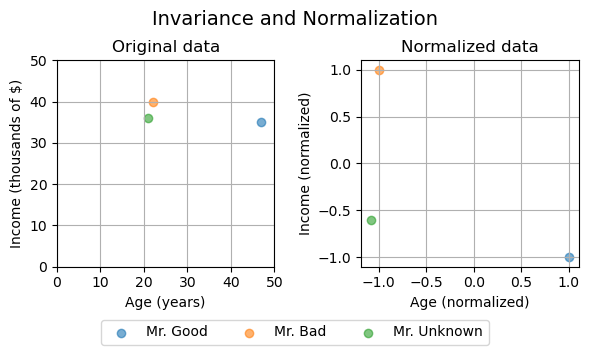

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
data = {
    'Mr. Good':     np.array([47, 35]),
    'Mr. Bad':      np.array([22, 40]),
    'Mr. Unknown':  np.array([21, 36])
}

# Calculate means
mean_x = np.mean([data['Mr. Good'][0], data['Mr. Bad'][0]])
mean_y = np.mean([data['Mr. Good'][1], data['Mr. Bad'][1]])

print(f'Mean of age: {mean_x}')
print(f'Mean of income: {mean_y}\n')

# Center the data (zero mean)
centered_data = {key: value - [mean_x, mean_y] for key, value in data.items()}

for key, value in centered_data.items():
    print(f'Centered coordinates for {key}: {value}')

# Calculate variances
var_x = np.var([centered_data['Mr. Good'][0], centered_data['Mr. Bad'][0]])
var_y = np.var([centered_data['Mr. Good'][1], centered_data['Mr. Bad'][1]])

print(f'\nVariance of age: {var_x}')
print(f'Variance of income: {var_y}')

# Calculate standard deviations
std_x = np.sqrt(var_x)
std_y = np.sqrt(var_y)

print(f'\nStandard deviation of age: {std_x}')
print(f'Standard deviation of income: {std_y}\n')

# Normalize the data (variance one)
normalized_data = {key: [value[0]/std_x, value[1]/std_y] for key, value in centered_data.items()}

for key, value in normalized_data.items():
    print(f'Normalized coordinates for {key}: {value}')

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Original data plot
for key, value in data.items():
    ax[0].scatter(value[0], value[1], label=key, alpha=0.6)
ax[0].set_title('Original data')
ax[0].set_xlabel('Age (years)')
ax[0].set_ylabel('Income (thousands of $)')
ax[0].grid(True)
ax[0].set_xlim(0, 50)
ax[0].set_ylim(0, 50)

# Normalized data plot
for key, value in normalized_data.items():
    ax[1].scatter(value[0], value[1], label=key, alpha=0.6)
ax[1].set_title('Normalized data')
ax[1].set_xlabel('Age (normalized)')
ax[1].set_ylabel('Income (normalized)')
ax[1].grid(True)

# Add a single legend for the entire figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=3)

plt.tight_layout()
plt.suptitle('Invariance and Normalization', fontsize=14, y=1.05)
plt.savefig('output/invariance_and_normalization.png')
plt.show()

# 3. Differentiable programming (35 points)

--------------------------------------------------
All results for SGD:
--------------------------------------------------
Combination 1:
Learning Rate: 0.1, Iterations: 5
Final value of function: 0.1489834040403366
--------------------------------------------------
Combination 2:
Learning Rate: 0.1, Iterations: 10
Final value of function: 0.04289386048913002
--------------------------------------------------
Combination 3:
Learning Rate: 0.1, Iterations: 15
Final value of function: 0.024618230760097504
--------------------------------------------------
Combination 4:
Learning Rate: 0.1, Iterations: 20
Final value of function: 0.01677996665239334
--------------------------------------------------
Combination 5:
Learning Rate: 0.1, Iterations: 25
Final value of function: 0.011724643409252167
--------------------------------------------------
Combination 6:
Learning Rate: 0.3, Iterations: 5
Final value of function: 0.022924814373254776
--------------------------------------------------
C

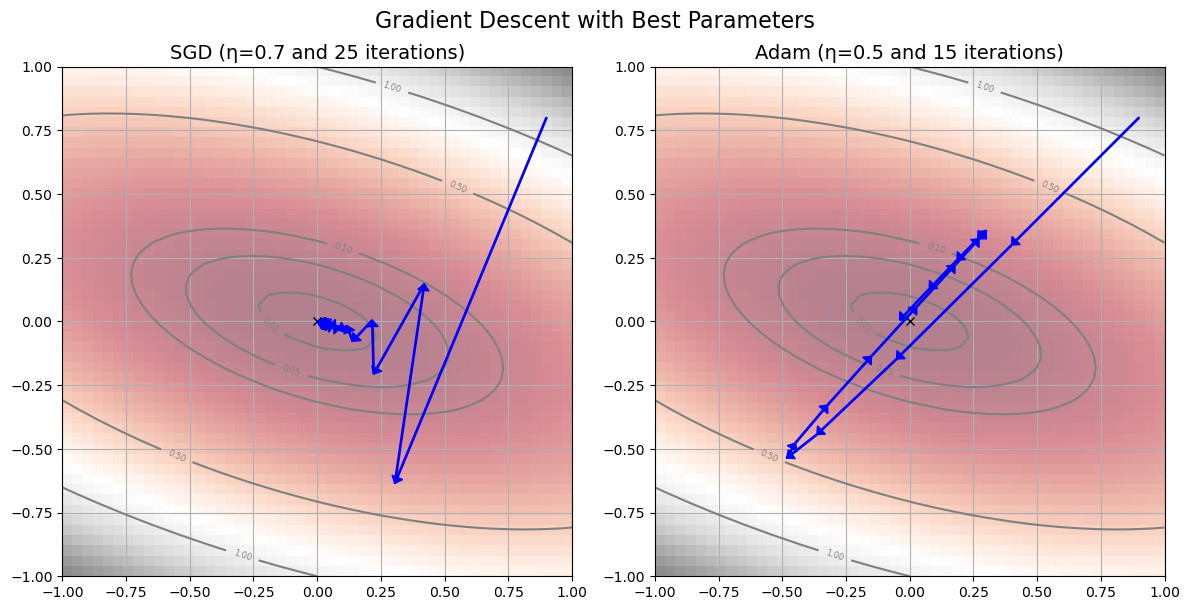

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Parameter affecting the shape of the quadratic function
p_f = 0.5

# Range for plotting the function
r = 1.

# Quadratic function definition
def f(x, y):
    """Compute the value of the function for given x and y."""
    return (p_f*x)**2 + y**2 + p_f*x*y

def gradient_descent_plot(optimizer_type, p_x, p_y, r, eta, n_iter, ax):
    """
    Plot the contour of the function and the gradient descent path on the given axis.
    
    Parameters:
    - p_x, p_y: Lists containing x and y coordinates of the gradient descent path.
    - r: Range for plotting.
    - n_iter: Number of iterations.
    - ax: Axis on which to plot.
    """

    # Generate meshgrid for contour plot
    x = np.linspace(-r, r, 50)
    y = np.linspace(-r, r, 50)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # Draw contour lines and fill on the given axis
    contours = ax.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.5, 1.], colors='grey')
    ax.clabel(contours, inline=True, fontsize=6)
    ax.imshow(Z, extent=[-r, r, -r, r], origin='lower', cmap='RdGy', alpha=0.5)

    # Mark the optimum point on the given axis
    ax.plot(0, 0, 'x', c='k')

    # Plot arrows showing the gradient descent path on the given axis
    for i in range(n_iter):
        ax.arrow(p_x[i], p_y[i], p_x[i+1]-p_x[i], p_y[i+1]-p_y[i], width=.005, head_width=.045, head_length=.025, length_includes_head=True, fc='b', ec='b', zorder=10)
    
    # Set title for the given axis
    ax.set_title(f'{optimizer_type} (η={eta} and {n_iter} iterations)', fontsize=14)
    ax.grid(True)

def perform_gradient_descent(optimizer_type, eta, n_iter, r, ax):
    """
    Perform gradient descent optimization and store the path.
    
    Parameters:
    - optimizer_type: Type of optimizer to use ('SGD' or 'Adam').
    - eta: Learning rate.
    - n_iter: Number of iterations.
    - r: Range for initial point.
    """
    # Initialize starting point
    x = torch.ones(1, requires_grad=True)
    y = torch.ones(1, requires_grad=True)
    with torch.no_grad():
        x *= 0.9*r
        y *= 0.8*r

    # Lists to store path of gradient descent
    p_x = [x.item()]
    p_y = [y.item()]

    # Choose optimizer based on input
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD([x, y], lr=eta)
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam([x, y], lr=eta)
    else:
        raise ValueError('Unsupported optimizer type')

    # Gradient descent loop
    for i in range(n_iter):
        optimizer.zero_grad()
        f(x, y).backward()
        optimizer.step()
        p_x.append(x.item())
        p_y.append(y.item())

    # Plot the results of gradient descent
    gradient_descent_plot(optimizer_type, p_x, p_y, r, eta, n_iter, ax)

def gradient_descent_grid_search(optimizer_type, learning_rates, iterations, r):
    best_eta = None
    best_n_iter = None
    best_value = float('inf')
    
    print('-' * 50)
    print(f'All results for {optimizer_type}:')
    print('-' * 50)
    
    combination_count = 1
    for eta in learning_rates:
        for n_iter in iterations:
            x = torch.ones(1, requires_grad=True)
            y = torch.ones(1, requires_grad=True)
            with torch.no_grad():
                x *= 0.9*r
                y *= 0.8*r
            if optimizer_type == 'SGD':
                optimizer = torch.optim.SGD([x, y], lr=eta)
            elif optimizer_type == 'Adam':
                optimizer = torch.optim.Adam([x, y], lr=eta)
            for _ in range(n_iter):
                optimizer.zero_grad()
                f(x, y).backward()
                optimizer.step()
            value = f(x, y).item()
            
            # Print the results for this combination
            print(f'Combination {combination_count}:')
            print(f'Learning Rate: {eta}, Iterations: {n_iter}')
            print(f'Final value of function: {value}')
            print('-' * 50)
            
            if value < best_value:
                best_value = value
                best_eta = eta
                best_n_iter = n_iter
                
            combination_count += 1

    print(f'Best Combination:')
    print(f'Learning Rate: {best_eta}, Iterations: {best_n_iter}')
    print(f'Final value of function: {best_value}')
    print('-' * 50)
                
    return best_eta, best_n_iter, best_value

# Define a range of learning rates and iterations to search over
learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
iterations = [5, 10, 15, 20, 25]

# Find the best parameters for SGD
best_eta_sgd, best_n_iter_sgd, best_value_sgd = gradient_descent_grid_search('SGD', learning_rates, iterations, r)

# Find the best parameters for Adam
best_eta_adam, best_n_iter_adam, best_value_adam = gradient_descent_grid_search('Adam', learning_rates, iterations, r)

# Plot using the best parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
perform_gradient_descent('SGD', best_eta_sgd, best_n_iter_sgd, r, ax=ax1)
perform_gradient_descent('Adam', best_eta_adam, best_n_iter_adam, r, ax=ax2)

plt.tight_layout()
plt.suptitle('Gradient Descent with Best Parameters', fontsize=16, y=1.02)
plt.savefig('output/gradient_descent.png')
plt.show()